In [1]:
from tensorflow.keras.datasets   import boston_housing , mnist , fashion_mnist
from tensorflow.keras.models     import Sequential , clone_model , Model , load_model
from tensorflow.keras.layers     import Dense , Activation , InputLayer , Flatten , Input , BatchNormalization , Dropout , Embedding

# CNN
from tensorflow.keras.layers     import Conv2D , MaxPooling2D , AveragePooling2D

from tensorflow.keras            import optimizers  
from tensorflow.keras.callbacks  import EarlyStopping , ModelCheckpoint , Callback
from tensorflow.keras.optimizers import SGD , Adam , RMSprop

# 이미지 로드
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# 자연어 처리
from tensorflow.keras.preprocessing.text          import Tokenizer
from tensorflow.keras.preprocessing.sequence      import pad_sequences

from keras.utils.np_utils      import to_categorical

from sklearn.datasets          import load_iris , load_breast_cancer , load_digits
from sklearn.model_selection   import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy  as np
import pandas as pd


In [2]:
# TPU 사용시
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.TPUStrategy(resolver)

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  9 05:17:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#X = np.load('/content/drive/MyDrive/Colab Notebooks/X_tra.npy')  

In [6]:
train_img_generator = ImageDataGenerator(rescale=1/255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
train_generator = train_img_generator.flow_from_directory(
    #'/content/drive/MyDrive/Colab Notebooks/image/kor_beer_bigsize/train' , 
    #'/content/drive/MyDrive/Colab Notebooks/image/맥주/국산맥주',
    #'/content/drive/MyDrive/Colab Notebooks/image/맥주',
    '/content/drive/MyDrive/Colab Notebooks/image/total_beer_label/통합',
    target_size = (300, 300) , 
    batch_size  = 20 ,
    class_mode = 'categorical'
)

Found 916 images belonging to 74 classes.


In [7]:
# test_img_generator = ImageDataGenerator(rescale=1/255,
#                                         rotation_range=40,
#                                         width_shift_range=0.2,
#                                         height_shift_range=0.2,
#                                         shear_range=0.2,
#                                         zoom_range=0.2,
#                                         horizontal_flip=True,
#                                         fill_mode='nearest')
# test_generator = test_img_generator.flow_from_directory(
#     '/content/drive/MyDrive/Colab Notebooks/image/kor_beer_bigsize/test' , 
#     target_size = (244, 244) , 
#     batch_size  = 20 ,
#     class_mode = 'categorical'
# )

In [8]:
def img_model() :
  img_model = Sequential()

  img_model.add( Conv2D(input_shape = (300, 300, 3) , filters = 16 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )
      
  img_model.add( Conv2D(filters = 32 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )

  img_model.add( Conv2D(filters = 64 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )

  img_model.add( Conv2D(filters = 64 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )

  img_model.add( Flatten() )
  img_model.add( Dense(units = 512) )
  img_model.add( Activation('relu') )
  img_model.add( Dropout(0.25) )
  
  img_model.add( Dense(units = 74) )
  img_model.add( Activation('softmax') )

  return img_model 


In [9]:
model = img_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 activation (Activation)     (None, 298, 298, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 149, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 147, 147, 32)      0         
                                                        

In [10]:
#strategy = tf.distribute.TPUStrategy(resolver)
model.compile(optimizer = RMSprop(lr = 0.001), 
                      loss= 'categorical_crossentropy' , 
                      metrics=['accuracy'] ) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [11]:
model_history = model.fit(train_generator , epochs = 100 ,  verbose = 1 )
#model_history = model.fit(train_generator , epochs = 15 , verbose = 1 , steps_per_epoch = 8 )

Epoch 1/100
46/46 [==============================] - 243s 5s/step - loss: 4.4082 - accuracy: 0.0186
Epoch 2/100
46/46 [==============================] - 26s 573ms/step - loss: 4.1516 - accuracy: 0.0295
Epoch 3/100
46/46 [==============================] - 27s 578ms/step - loss: 3.7279 - accuracy: 0.1037
Epoch 4/100
46/46 [==============================] - 26s 575ms/step - loss: 3.2057 - accuracy: 0.1867
Epoch 5/100
46/46 [==============================] - 26s 573ms/step - loss: 2.7958 - accuracy: 0.2533
Epoch 6/100
46/46 [==============================] - 26s 574ms/step - loss: 2.5440 - accuracy: 0.3199
Epoch 7/100
46/46 [==============================] - 26s 570ms/step - loss: 2.1837 - accuracy: 0.3821
Epoch 8/100
46/46 [==============================] - 26s 571ms/step - loss: 2.0583 - accuracy: 0.4094
Epoch 9/100
46/46 [==============================] - 26s 572ms/step - loss: 1.7676 - accuracy: 0.4967
Epoch 10/100
46/46 [==============================] - 26s 574ms/step - loss: 1.6527 

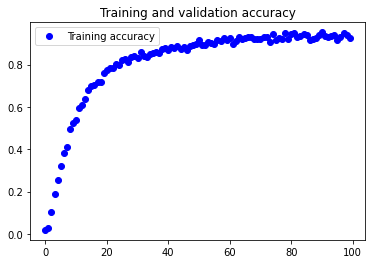

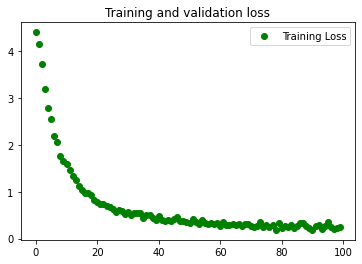

In [12]:
import matplotlib.pyplot as plt

acc = model_history.history['accuracy']
#val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
#plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
n_img = train_generator.n
steps = n_img // 20
print('생성된 총 이미지 수 : ',n_img , '실행 횟수 : ' , steps)

생성된 총 이미지 수 :  916 실행 횟수 :  45


In [14]:
labels = train_generator.classes
print(len(labels))

916


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
썸머스비


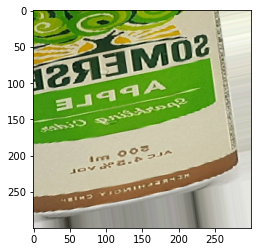

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
스텔라


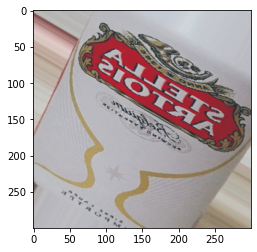

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
경복궁


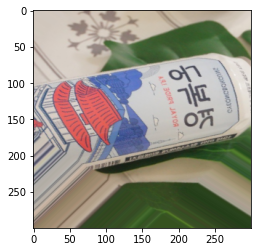

In [15]:

file = open('/content/drive/MyDrive/Colab Notebooks/image/total_beer_label/labels.txt', "r", encoding='utf8')

lines = []
while True:
    line = file.readline().replace('라벨', '').strip()
    if not line:
        break
    #print(line)
    lines.append(line)

x,y = train_generator.next()
for i in range(0,3):
    image2 = x[i]
    label2 = y[i]
    print (label2)
    for idx, val in enumerate(label2):
      if(val == 1.):
        print(lines[idx])
    plt.imshow(image2)
    plt.show()


In [16]:
# Keras 모델 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcwn_s7fr/assets


In [17]:
# 변환한 모델 tflite로 저장
with open('/content/drive/MyDrive/Colab Notebooks/2022_05/beer_model_220509_label_300_300.tflite', 'wb') as f:
  f.write(tflite_model)
  

In [19]:

from google.colab import files
upload_img = files.upload()
print(upload_img)
print(upload_img.keys())

for fn in upload_img.keys():
  print('file name - ', fn)
  path = '/content/' + fn 
  #img = image.load_img(path, target_size = (150, 150))
  img = image.load_img(path, target_size = (244, 244))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  image_ = np.vstack([x])
  print('model.output_mask : ', model.output_mask)
  
  classes = model.predict(image_, batch_size = 10)
  print('pred - ', classes)
  
  
print('예측하기 - ')

KeyboardInterrupt: ignored